In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import SVD
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

### 1. Read and explore the given dataset:

In [2]:
Data = pd.read_csv('Electronic_dataset.csv')

In [3]:
Electronic_dataset = Data.drop('timestamp', axis=1)

In [4]:
Electronic_dataset.head(5)

,user_id,prod_id,ratings
0,A3L1GVWVJKWZZS,B0058UUR6E,5.0
1,A08831071BVKZMKNCPI5S,B009ID0VVS,5.0
2,A1SINU2I4IOPNU,B000GBO9IM,4.0
3,A3P3P31EEOX2BD,B00CDCIOHO,3.0
4,A3DBLJ3MPBJQMN,B000MS3VGA,5.0


In [5]:
Electronic_dataset.shape

(500000, 3)

In [6]:
Electronic_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 3 columns):
user_id    500000 non-null object
prod_id    500000 non-null object
ratings    500000 non-null float64
dtypes: float64(1), object(2)
memory usage: 11.4+ MB


In [7]:
Electronic_dataset.isnull().any().sum()

0

In [8]:
Electronic_dataset.describe()

,ratings
count,500000.000000
mean,4.013172
std,1.379996
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


#### Plot Histogram:

Text(0, 0.5, 'Total no. of ratings')

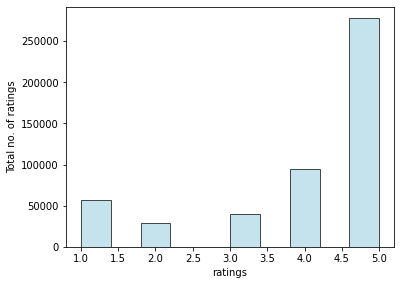

In [9]:
plt.figure(figsize= (20,15))
plt.subplot(3,3,1)
plt.hist(Electronic_dataset['ratings'], color='lightblue', edgecolor = 'black', alpha = 0.7)
plt.xlabel('ratings')
plt.ylabel('Total no. of ratings')

### 2. Taking subset of the dataset

In [10]:
subset=Electronic_dataset.iloc[:300000,0:]

In [11]:
subset.shape

(300000, 3)

In [12]:
print("\nTotal no of ratings :",subset.shape[0])
print("Total No of Users   :", len(np.unique(subset.user_id)))
print("Total No of products  :", len(np.unique(subset.prod_id)))


Total no of ratings : 300000
Total No of Users   : 278755
Total No of products  : 96708


## 3. Popularity based Recommendation model

In [13]:
new_df=subset.groupby("prod_id").filter(lambda x:x['ratings'].count() >=50)

In [14]:
new_df

,user_id,prod_id,ratings
0,A3L1GVWVJKWZZS,B0058UUR6E,5.0
6,A2PIF6JQQYOGPG,B00007E7JU,4.0
19,A1N08U9HNS7GCM,B007R5YDYA,5.0
31,A1ZS78VULYT6X9,B005USRBVI,5.0
56,AEVTQOV2XU46A,B009SYZ8OC,1.0
...,...,...,...
299979,A3W53PEY0JN1S4,B003FVVMS0,5.0
299987,A19YIXNURUGK6I,B007R5YDYA,4.0
299989,A3R1GXHF8XUGWV,B003ES5ZUU,5.0
299991,A29THQFOAB9U4U,B009WU5XUG,5.0


In [15]:
new_df.groupby(by='prod_id')['ratings'].count().sort_values(ascending=False).head()

prod_id
B0074BW614    698
B00DR0PDNE    647
B007WTAJTO    539
B0019EHU8G    470
B006GWO5WK    465
Name: ratings, dtype: int64

In [16]:
new_df.groupby('prod_id')['ratings'].mean().sort_values(ascending=False).head()

prod_id
B003FVVMS0    4.915493
B0043WJRRS    4.855556
B0052SCU8U    4.840336
B003XM1WE0    4.827586
B00D856NOG    4.816667
Name: ratings, dtype: float64

In [17]:
ratings_mean_count = pd.DataFrame(new_df.groupby('prod_id')['ratings'].mean())

In [18]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('prod_id')['ratings'].count())

In [19]:
ratings_mean_count.head()

,ratings,rating_counts
prod_id,,
B00001P4ZH,4.247059,85
B00001WRSJ,4.653846,52
B00004T8R2,4.303571,56
B00004ZCJE,4.049505,101
B00005N6KG,4.037736,53


In [20]:
ratings_mean_count['rating_counts'].max()

698

In [21]:
train_data_sort = ratings_mean_count.sort_values(['rating_counts', 'ratings'], ascending = [0,1]) 
train_data_sort.head(5)

,ratings,rating_counts
prod_id,,
B0074BW614,4.459885,698
B00DR0PDNE,3.986090,647
B007WTAJTO,4.448980,539
B0019EHU8G,4.744681,470
B006GWO5WK,4.294624,465


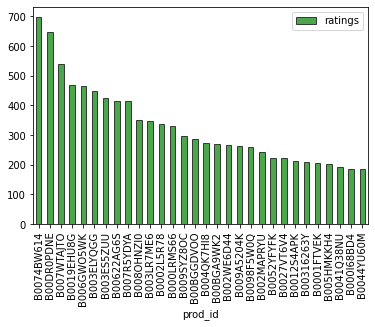

In [22]:
popular_products = pd.DataFrame(new_df.groupby('prod_id')['ratings'].count())
most_popular = popular_products.sort_values('ratings', ascending=False)

most_popular.head(30).plot(kind = "bar",color='green', edgecolor = 'black', alpha = 0.7)

### 4. Split the data randomly into a train and test dataset. ( For example, split it in 70/30 ratio)

In [23]:
counts = pd.value_counts(Electronic_dataset['user_id'])
rating_explicit = Electronic_dataset[Electronic_dataset['user_id'].isin(counts[counts >=5].index)]

In [24]:
rating_explicit.shape

(8447, 3)

In [25]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_explicit,reader)

In [26]:
trainset, testset = train_test_split(data, test_size=.30, random_state=4)

## 5. Collaborative Filtering model

### SVD Algorithm

In [27]:
algo_svd = SVD()

algo_svd.fit(trainset)

predictions_SVD = algo_svd.test(testset)

### 6. Evaluate the model

In [28]:
print("User-based Model : Test Set")

accuracy.rmse(predictions_SVD)
accuracy.mse(predictions_SVD)
accuracy.fcp(predictions_SVD)
accuracy.mae(predictions_SVD)

User-based Model : Test Set
RMSE: 1.0562
MSE: 1.1156
FCP:  0.4713
MAE:  0.8136


0.8136494195683035

####  5-fold cross-validation:

In [29]:
from surprise.model_selection import cross_validate
cross_validate(algo_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)  

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0445  1.0449  1.0679  1.0325  1.0764  1.0532  0.0163  
MAE (testset)     0.8147  0.8041  0.8184  0.7931  0.8208  0.8102  0.0103  
Fit time          0.77    0.67    0.67    0.80    0.88    0.76    0.08    
Test time         0.01    0.02    0.01    0.03    0.01    0.02    0.01    


{'test_rmse': array([1.04447731, 1.04489878, 1.06788923, 1.03252651, 1.07642882]),
 'test_mae': array([0.81473133, 0.80405304, 0.81841527, 0.79314455, 0.82080229]),
 'fit_time': (0.7745544910430908,
  0.6706132888793945,
  0.6676352024078369,
  0.8005404472351074,
  0.879493236541748),
 'test_time': (0.014989852905273438,
  0.015991687774658203,
  0.011993408203125,
  0.026982784271240234,
  0.012989997863769531)}

In [30]:
from collections import defaultdict

def get_top_n(predictions_SVD, n=5):
    
   # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions_SVD:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [31]:
top_n = get_top_n(predictions_SVD, n=5)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A2294LS59GC5K7 ['B0093HGD2K', 'B0042LF23I', 'B003DTLV8K']
A328S9RN3U5M68 ['B00IRX1NXK', 'B00L2442H0', 'B00ABIVN16', 'B00A1DJO12', 'B0097BEFYA']
A20G074MWH9U7O ['B001DQKHX0', 'B004285MF4']
A1KOOC0V1UWJJQ ['B001QWW0D6', 'B0009MIP8I', 'B004V94F5C']
A3V15SFD7918WZ ['B005H7TMA0', 'B005ES0YYA']
A17W0GMB0YY83M ['B005FYNSPK', 'B007019HJW', 'B00004Z5D1']
A1MJMYLRTZ76ZX ['B00GYI88TW', 'B00008K4BD', 'B00006HYFE', 'B0009H5VVM']
A2WLDEORTNRY0D ['B0047E8DN6']
A1XTSL9WZW301S ['B00FQJ077Q', 'B008TLQ5RY', 'B00B1R8JT0']
AIA5WY7MZG3J ['B00546JLP0', 'B003Y6UNI6']
A3LGT6UZL99IW1 ['B007G5NNOW', 'B005DMBUZY', 'B003MRPERC', 'B001EYTPO8', 'B00006I53X']
A2VTUV7ITLS8IK ['B0026O0LN4', 'B005DKZTMG']
A20403BR0K7VM8 ['B004J13VW0', 'B00E6N9GS4']
A2O168CJIAEGL5 ['B000GAS3A8', 'B00002NDRQ', 'B00006JPRQ', 'B005CV9LN4']
AF76AAXINSF5E ['B0088O721K', 'B001DHK7RA']
AOWF9T81XMX2S ['B005IHAIJ8', 'B00A35WUZA']
A11I1I9QLMAM1A ['B00B9LGDVE', 'B002V5M5E6']
AA8JEQP5MBJJQ ['B000BSN4UY', 'B000EIZPLM']
A18U49406IPPIJ ['B00JQTNVL6', '

A20H1M28WLI9J2 ['B0038KN114']
A132CBT7KF85K9 ['B00DTKZKQM']
A7V03VUWQLLI5 ['B0000A4F05', 'B002FC10EG']
A1C5TCCR2IGKBU ['B001OI2YZQ', 'B001QWKDO4', 'B004TJ6JH6']
A3VBORHS4H8LES ['B0019EHU8G']
A38X9XX2ZRR0ON ['B00166BNI0', 'B004KPLS7K']
A12JYLOG4UMP77 ['B000ATT8I6', 'B003ELYQGG']
A2OGHYF3EW3XQD ['B000B9RI14', 'B00017LSPI', 'B005UFZ7F8']
A3OHV1J3JGC56O ['B00AKT96GU']
A64LEAZ2QF8L2 ['B008Y2SPH6', 'B0001HWL9A', 'B00008KA6Z', 'B00CQBBBW2']
A3UXW18DP4WSD6 ['B0045HG53K', 'B009HK30V0']
A3MWMO2IOQDWBJ ['B00004T8R2', 'B0006I09OS']
A3GQY0TFRG0MPZ ['B0043BNF4U', 'B003V42O6K']
A23GFTVIETX7DS ['B001GND6EW', 'B00AR95FOU', 'B009T65WXG', 'B000W6O08A', 'B002QC6RI4']
A3QJU4FEN8PQSZ ['B00ATM1MVU', 'B0082YEH8M', 'B005GM1Q1O']
A17UNMURMLX0ZE ['B00829TIEK', 'B007GR44PM', 'B003BYRGJU']
AAA0TUKS5VBSA ['B007W2ZDX8', 'B003F5NS9W']
AOEDWQLH2WKKW ['B00BDS0512', 'B003WE9MCI', 'B003725D32']
A3IY316DRNF5F2 ['B0011Z2402', 'B000TR7AIO', 'B000MGFUUW']
A2DRYHBYLO5S8T ['B00006DY6M']
A3VI2VETB90ZG5 ['B00IVFDZBC', 'B003924UB

A33YZNZIRA3H97 ['B0009HN57O']
ALHC64J88LVWO ['B00E3AKF1C', 'B00C4N410G', 'B00BBH7YGE']
A2JWF9IG8PJAOA ['B006MRAVFE', 'B004MF11MU', 'B005IS4SG6']
ARUDTZ5BNUHA6 ['B0000DCRHA', 'B004EAMFDC']
A1EX7MNFZYL58 ['B004RBX0GO']
A236V1U1P2K4OG ['B007UQ46LQ', 'B004OBZM8G', 'B000F28DP2']
A2KCNRFE5NL5B6 ['B006HIKIG0', 'B008OEHPKM']
A1TT5YBX2MXKQX ['B003FSTAGY', 'B002GCR04Y', 'B00685ZCZY']
AONUCJBC85BL ['B00171MWU2', 'B0026P3CHA', 'B0036VO6IC']
A32G54YHK6OGO4 ['B000WXA17W']
A2NDMKZIM7FOOB ['B005HMKKH4', 'B000E128SM']
A24L7CNCQY0FT4 ['B005GNR9P0']
A285W3N2KHGII1 ['B000KN8QMQ', 'B00009V6U0']
A1OMXVXXP07F05 ['B00AAHTQ30', 'B003VNKKUS']
A13WOT3RSXKRD5 ['B001J0K9RO']
A3284KYDZ00BZA ['B004ETQHDM']
A316XO4RWX21YN ['B00945RAQY', 'B00FPKDPZC']
A1CYTBE7LLUQ8F ['B000B6MQU0', 'B0062IPIPQ', 'B000EXTXSI']
AFJ6ZVBQG4LRK ['B000E3ZFSA', 'B00067KZJI']
A2F4HP0J5VNOYR ['B0009YWCT4', 'B005FVDTAW']
A492TJ4AHEQ5D ['B003SRYNRS', 'B000E9VJG6']
A2RGWCT6K2C3EZ ['B00761ZRG8', 'B00HYAL84G']
A3M82NO6OU1FHS ['B00006B7DA']
AUGXK02BJ

### k nearest neighbors

In [32]:
algo = KNNWithMeans(k=10, sim_options={'name': 'pearson_baseline', 'user_based': True})

algo.fit(trainset)

predictions = algo.test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [33]:
print("User-based Model : Test Set")

accuracy.rmse(predictions)
accuracy.mse(predictions)
accuracy.fcp(predictions)
accuracy.mae(predictions)

User-based Model : Test Set
RMSE: 1.1028
MSE: 1.2161
FCP:  0.4426
MAE:  0.8470


0.8469606629438042

In [34]:
def get_top_n(predictions, n=5):
    
   # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=5)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A2294LS59GC5K7 ['B0042LF23I', 'B003DTLV8K', 'B0093HGD2K']
A328S9RN3U5M68 ['B00IRX1NXK', 'B0097BEFYA', 'B00L2442H0', 'B00ABIVN16', 'B00A1DJO12']
A20G074MWH9U7O ['B001DQKHX0', 'B004285MF4']
A1KOOC0V1UWJJQ ['B001QWW0D6', 'B0009MIP8I', 'B004V94F5C']
A3V15SFD7918WZ ['B005H7TMA0', 'B005ES0YYA']
A17W0GMB0YY83M ['B005FYNSPK', 'B00004Z5D1', 'B007019HJW']
A1MJMYLRTZ76ZX ['B00GYI88TW', 'B00008K4BD', 'B00006HYFE', 'B0009H5VVM']
A2WLDEORTNRY0D ['B0047E8DN6']
A1XTSL9WZW301S ['B00FQJ077Q', 'B008TLQ5RY', 'B00B1R8JT0']
AIA5WY7MZG3J ['B00546JLP0', 'B003Y6UNI6']
A3LGT6UZL99IW1 ['B003AM8S3G', 'B007G5NNOW', 'B002BH3Z8E', 'B005DMBUZY', 'B003MRPERC']
A2VTUV7ITLS8IK ['B005DKZTMG', 'B0026O0LN4']
A20403BR0K7VM8 ['B004J13VW0', 'B00E6N9GS4']
A2O168CJIAEGL5 ['B000GAS3A8', 'B00002NDRQ', 'B00006JPRQ', 'B005CV9LN4']
AF76AAXINSF5E ['B0088O721K', 'B001DHK7RA']
AOWF9T81XMX2S ['B005IHAIJ8', 'B00A35WUZA']
A11I1I9QLMAM1A ['B00B9LGDVE', 'B002V5M5E6']
AA8JEQP5MBJJQ ['B000BSN4UY', 'B000EIZPLM']
A18U49406IPPIJ ['B00JQTNVL6', '

ADLVFFE4VBT8 ['B001XURP7W', 'B009NHWVIA', 'B00HHRP11C', 'B001CCGYJG', 'B001JKIHAU']
A19HT7YC1UW3D6 ['B001A4HAFS', 'B007OXK0YM']
AQH4M199E4C11 ['B00GFZMI3G']
A3T7V207KRDE2O ['B000N7VPRW', 'B004P6NU8O', 'B000KZ70JE', 'B001G9WAF2', 'B002OGMNT4']
A125H61XJXCB1G ['B00CRXTKIG', 'B000Z80ICM']
A358AZ20WPULEQ ['B003551SNA']
AQIJ3ZEEVCIKU ['B001CIREXA', 'B0020HR7DE']
A28AHI180H69GK ['B00261HV2Q', 'B005GNR9G4', 'B001762LE4', 'B003GIJTR8']
A20VG5W98SX99L ['B006K550J0', 'B005ELBSWO']
A2SL5IW096Z2BL ['B0018MEBNG', 'B0009T035E', 'B00076RJV0', 'B004R26IYE']
A1V3LIFQNWB1FQ ['B000HJPK0Y']
A22RY8N8CNDF3A ['B005OTPVMY', 'B001RI7NRC']
A1VHCO8RQFIGQJ ['B000YHGAMG', 'B0012IJYZ6', 'B0031AQ302', 'B001CBDGHA']
A32LX4XJ2LU740 ['B001MTE32Y', 'B005KFONIU', 'B00GJFP0IM']
ALUV2YKWZENKK ['B009M3UUNI', 'B00CNZP7H6', 'B0097CZHAU']
A1ZU55TM45Y2R8 ['B001EJJ2UU', 'B00IAELTLM']
ATS2855497V0I ['B0000CNZRZ', 'B004HO58SO']
A30JPZ9TZ7I61U ['B007BY0MIS']
A2VODABWSVHV8E ['B004K1EZDS', 'B000JE5CKA']
A1H98YV5K5BUX0 ['B000TXZIDM', 

A33H8EDNC4K5EI ['B001GZZCVK', 'B00ELAM8LE', 'B0054U39QS']
A356RFKNIG043B ['B00HSQAIQU']
A1HBI9BBQIG1NH ['B00EN27TCI', 'B007ZW7YJQ', 'B000BUEMOO']
A1LH6RF4UN9VI6 ['B00829TIA4']
A2WPL6Y08K6ZQH ['B00AM4A87O', 'B0040QE98O']
A1THSBWV04YAIK ['B0017JE9T6', 'B00355IJU0']
A1CST2WUA32GP0 ['B00CXUYTTS', 'B003VANO7C']
A1RJMEVTRP7EB ['B00BWYLGI8']
A6VXZ1EEPRTLV ['B002VFFA5M', 'B000R9AAJA', 'B002V88HFE']
A1TT4CY55WLHAR ['B009BVK1YO', 'B00478O0JI']
AL1VDLRRY5UEP ['B00068S59Y', 'B002OR6OFW']
A15G70V9OBTOVO ['B00K8942SO']
A4U27URFECK1U ['B006427IY4', 'B007X3VC9A', 'B00C9TECFO']
A2AX2UGB167J31 ['B000Q9UFKU', 'B0038OHGDE']
A1VOFY3QFT9WCG ['B007NZGPAY', 'B006EKIQYM']
A107D9T206Z36 ['B00009R8DD']
ASPU6ADKLXPRT ['B000VXKD8K', 'B005B111II']
A328GLDSDNFYII ['B006GIDY58', 'B003OA8T92']
A3NGABXDIB0POU ['B007WTAJTO']
A1QNYLBG73QRNF ['B0006AZ57M']
A2SYAQXJGRY3XE ['B00CQ838VM', 'B000NUYW92', 'B00009UTZA']
ARQ4HTA950LU9 ['B005ODKCH4', 'B0040RWN0O']
A3GMU0VTI9IPEP ['B00392141U', 'B0007MGG2M', 'B00007KDVI']
A2L9OPJAA

A1B6SIX2I161O9 ['B003FMVPFY']
AMS2CPERWN7JV ['B001LK8P14', 'B000GAUZFO']
AHT4UI0DBJSOY ['B004XD8KXE']
A3KNGMX2RVQG91 ['B00AXX0I88']
A3077MQTAKOVFZ ['B003BT69Z2', 'B007DL79FS', 'B003BYRGJU']
AKIK9H3SZZPLH ['B004CM4A58', 'B007VGGIB6']
A11T807LX2EF00 ['B0079TOI8K', 'B0012GQZZU', 'B009M27MB2']
A3PJJTAKISAFI9 ['B000BGZ0BM']
A1EVV74UQYVKRY ['B00G4V0QSK']
A16HXVNPU5TCGE ['B005PYZG6E']
A16WP8NTPYB0ZM ['B000E9VKK6']
A250AXLRBVYKB4 ['B001H5T7LK', 'B0017U9PYY']
A1N3EH28S4DI8L ['B002NO7PWC']
A1W415JP5WEAJK ['B007OY5V68']
A2U3OEIK1CUPIK ['B005ESY8VA', 'B00IPMFG54']
AHIK7BUXFRMT8 ['B003C2YOE6', 'B002K9IHGI']
A1Z7U9K6X3FEOU ['B002WP2QGM']
AD8DLOGHAXL ['B0028A1NRY']
A3IMALU0RM8UT9 ['B000QUUFRW', 'B0082E9K7U']
A3I60EG7VWNJ0 ['B00007056H']
A1KXJCXS6HFRQZ ['B001TOD7ME']
A23QII83UGZP5U ['B00I3ERXWS']
A185O1MX1RP964 ['B0046XUMDW', 'B001VEAI74']
A3QQGPI3CTV9SX ['B0013DXVYK', 'B00005LEN4', 'B0013BT8US']
A2G2QNKDL1Y6AC ['B009B0X9PI']
A3BKNXX8QFIXIV ['B00BD7UVHG']
A1GWG5CWLKJ7ET ['B0061HMPWM']
A3LKN9GND01EWJ [

###  7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [35]:
new_df1=new_df
ratings_matrix = new_df1.pivot_table(values='ratings', index='user_id', columns='prod_id', fill_value=0)
ratings_matrix.head()

prod_id,B00001P4ZH,B00001WRSJ,B00004T8R2,B00004ZCJE,B00005N6KG,B000065BP9,B000067RC4,B00007E7C8,B00007E7JU,B00007EDM8,...,B00DR0PDNE,B00DVFLJDS,B00E055H5O,B00E3W15P0,B00E98O7GC,B00EF1OGOG,B00EL93M3S,B00EYW9DSU,B00FNPD1VW,B00GTGETFG
user_id,,,,,,,,,,,,,,,,,,,,,
A0009878M2RGMMHGJH39,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A004176027NXFTHNBG3MW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A005721627VX5W2COKKK2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A01162511UO7BE3203XT3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A01168793VD8T3K6NVT3O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
ratings_matrix['user_index'] = np.arange(0, ratings_matrix.shape[0], 1)
ratings_matrix.head()

prod_id,B00001P4ZH,B00001WRSJ,B00004T8R2,B00004ZCJE,B00005N6KG,B000065BP9,B000067RC4,B00007E7C8,B00007E7JU,B00007EDM8,...,B00DVFLJDS,B00E055H5O,B00E3W15P0,B00E98O7GC,B00EF1OGOG,B00EL93M3S,B00EYW9DSU,B00FNPD1VW,B00GTGETFG,user_index
user_id,,,,,,,,,,,,,,,,,,,,,
A0009878M2RGMMHGJH39,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A004176027NXFTHNBG3MW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
A005721627VX5W2COKKK2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
A01162511UO7BE3203XT3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
A01168793VD8T3K6NVT3O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [37]:
ratings_matrix.set_index(['user_index'], inplace=True)

ratings_matrix.head()

prod_id,B00001P4ZH,B00001WRSJ,B00004T8R2,B00004ZCJE,B00005N6KG,B000065BP9,B000067RC4,B00007E7C8,B00007E7JU,B00007EDM8,...,B00DR0PDNE,B00DVFLJDS,B00E055H5O,B00E3W15P0,B00E98O7GC,B00EF1OGOG,B00EL93M3S,B00EYW9DSU,B00FNPD1VW,B00GTGETFG
user_index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
matrix = ratings_matrix.astype(float)
U, sigma, Vt = svds(matrix)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [39]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = matrix.columns)
preds_df.head()

prod_id,B00001P4ZH,B00001WRSJ,B00004T8R2,B00004ZCJE,B00005N6KG,B000065BP9,B000067RC4,B00007E7C8,B00007E7JU,B00007EDM8,...,B00DR0PDNE,B00DVFLJDS,B00E055H5O,B00E3W15P0,B00E98O7GC,B00EF1OGOG,B00EL93M3S,B00EYW9DSU,B00FNPD1VW,B00GTGETFG
0,1.093294e-10,-8.541733e-26,4.047920e-12,3.748900e-12,7.664107e-17,-3.362658e-16,2.798318e-15,3.588327e-10,1.203047e-14,5.408437e-18,...,3.609701e-07,9.523810e-10,5.965151e-10,2.868444e-12,3.222894e-12,-9.658254e-24,3.473350e-23,-9.170069e-14,3.279214e-12,-4.333416e-11
1,-6.260374e-13,1.091916e-23,5.678786e-12,7.041724e-11,3.384264e-14,1.070469e-16,2.299203e-14,4.684165e-10,3.269527e-12,5.223142e-17,...,6.857105e-07,2.133061e-09,1.448107e-10,7.613968e-11,1.706760e-09,-7.069964e-21,2.089961e-20,5.553394e-14,4.944982e-12,1.543432e-11
2,5.871014e-11,-6.848161e-24,2.069266e-10,2.219585e-10,4.304908e-16,3.918738e-15,1.762016e-13,-3.265372e-12,4.900272e-13,3.400492e-16,...,3.196208e-05,8.865767e-08,5.450512e-10,2.293184e-10,6.982723e-14,-4.235837e-24,4.721584e-22,1.137258e-12,1.258590e-10,5.690275e-10
3,1.393597e-20,1.100598e-35,-1.197067e-21,1.042367e-21,-8.685194e-27,-4.644312e-25,-4.670026e-25,2.020470e-19,6.240688e-25,-8.920738e-28,...,5.960119e-17,9.325965e-20,-6.077165e-19,4.910009e-22,-6.793182e-23,-1.390004e-33,1.711502e-32,-1.392851e-22,1.241877e-21,-7.158494e-20
4,3.355488e-14,6.368352e-30,3.326163e-15,1.758923e-16,7.083011e-20,4.079703e-18,7.176064e-19,5.294875e-15,6.819288e-18,1.376898e-21,...,4.963523e-12,6.004126e-13,5.102188e-13,1.912124e-16,3.236465e-15,-8.970664e-27,2.978738e-26,1.183002e-15,1.140237e-16,5.912779e-13


##### Recommend the items with the highest predicted ratings

In [40]:
def recommend_items(user_id, num_recommendations):
      
    user_idx = user_id-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = matrix.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(user_id))
    print(temp.head(num_recommendations))

### Top 5 recommendations

In [41]:
user_id = 12
num_recommendations = 5
recommend_items(user_id, num_recommendations)


Below are the recommended items for user(user_id = 12):

                   user_ratings  user_predictions
Recommended Items                                
B0074BW614                  0.0          0.004577
B006GWO5WK                  0.0          0.000086
B0019EHU8G                  0.0          0.000030
B00902SFC4                  0.0          0.000011
B0043WJRRS                  0.0          0.000009


In [42]:
user_id = 100
num_recommendations = 5
recommend_items(user_id, num_recommendations)


Below are the recommended items for user(user_id = 100):

                   user_ratings  user_predictions
Recommended Items                                
B007R5YDYA                  0.0      1.996165e-07
B003ES5ZUU                  0.0      8.450091e-08
B007WTAJTO                  0.0      6.455675e-08
B0019EHU8G                  0.0      1.730108e-08
B00622AG6S                  0.0      3.036675e-09


## 8. Summary insights:

1. In popularity-based recommender model, recommendations remain the same for all users as We predict the products based on    the popularity. 

2. It is not personalized to particular user, but usefull for the new user who just signed up.

3. Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the    user and it is not dependent on any additional information.

4. In the Popularity-based recommender system recommendations are based on frequecy counts, which may be not suitable to      the user.

5. we can see the differance above for the user id 12 & 100, The Popularity based model has recommended the same set of        products to both but Collaborative Filtering based model has recommended entire different list based on the user past      purchase history.